# Species Distribution Modeling (SDM) – Gyps indicus

This notebook implements a **presence-only SDM** using **Kernel Density Estimation (KDE)**
trained in environmental space using **python**.                        
<br>

*Spatial data engineering, environmental raster sampling, spatial smoothing,
and final habitat suitability mapping* are performed in **Google Earth Engine**.





In [2]:
import pandas as pd
import numpy as np

In [ ]:
df1 = pd.read_csv('0022518-251009101135966.csv', sep='\t', on_bad_lines='skip')

In [ ]:
# Count and display top 5 species with their counts
top5_species = df1['scientificName'].value_counts().reset_index()
top5_species.columns = ['scientificName', 'count']

print("Top 5 species by number of occurrences:")
print(top5_species.head(5))

Top 5 species by number of occurrences:
                           scientificName  count
0            Gyps indicus (Scopoli, 1786)  12534
1         Gyps bengalensis (Gmelin, 1788)  11290
2        Sarcogyps calvus (Scopoli, 1786)   9357
3        Gyps tenuirostris G.R.Gray, 1844   1811
4  Houbaropsis bengalensis (Gmelin, 1789)   1438


In [ ]:
# Filter the DataFrame to keep only 'Gyps indicus (Scopoli, 1786)' species
gyps_indicus_df = df1[df1['scientificName'] == 'Gyps indicus (Scopoli, 1786)'].copy()

# Display the head of the filtered DataFrame
print("Filtered DataFrame (Gyps indicus only):")
display(gyps_indicus_df.head())

Filtered DataFrame (Gyps indicus only):


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,984448535,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS206217415,Animalia,Chordata,Aves,Accipitriformes,Accipitridae,Gyps,Gyps indicus,...,NaN,NaN,CC_BY_4_0,NaN,obsr163891,NaN,NaN,2025-10-08T14:36:18.783Z,NaN,CONTINENT_DERIVED_FROM_COORDINATES
2,980351658,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS246168486,Animalia,Chordata,Aves,Accipitriformes,Accipitridae,Gyps,Gyps indicus,...,NaN,NaN,CC_BY_4_0,NaN,obsr330147,NaN,NaN,2025-10-08T14:35:19.898Z,NaN,CONTINENT_DERIVED_FROM_COORDINATES
3,980224620,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS243945292,Animalia,Chordata,Aves,Accipitriformes,Accipitridae,Gyps,Gyps indicus,...,NaN,NaN,CC_BY_4_0,NaN,obsr447642,NaN,NaN,2025-10-08T14:31:38.022Z,NaN,CONTINENT_DERIVED_FROM_COORDINATES
9,980038241,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS242515579,Animalia,Chordata,Aves,Accipitriformes,Accipitridae,Gyps,Gyps indicus,...,NaN,NaN,CC_BY_4_0,NaN,obsr437205,NaN,NaN,2025-10-08T14:32:16.198Z,NaN,CONTINENT_DERIVED_FROM_COORDINATES
18,979633311,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,URN:catalog:CLO:EBIRD:OBS240789312,Animalia,Chordata,Aves,Accipitriformes,Accipitridae,Gyps,Gyps indicus,...,NaN,NaN,CC_BY_4_0,NaN,obsr131029,NaN,NaN,2025-10-08T14:37:05.002Z,NaN,CONTINENT_DERIVED_FROM_COORDINATES


In [ ]:
# Save the filtered DataFrame to a new CSV file
gyps_indicus_df.to_csv('gyps_indicus_data.csv', index=False)

print("Filtered data saved to 'gyps_indicus_data.csv'")

Filtered data saved to 'gyps_indicus_data.csv'


In [ ]:
# List of columns to keep
columns_to_keep = ['gbifID', 'locality', 'stateProvince', 'individualCount', 'decimalLatitude', 'decimalLongitude', 'day', 'month', 'year']

# Create a new DataFrame with only the specified columns
gyps_indicus_subset_df = gyps_indicus_df[columns_to_keep].copy()

# Display the head of the new DataFrame
print("DataFrame with selected columns:")
display(gyps_indicus_subset_df.head())

DataFrame with selected columns:


,gbifID,locality,stateProvince,individualCount,decimalLatitude,decimalLongitude,day,month,year
0,984448535,Ranthambore NP--entry road & fort,Rajasthan,NaN,26.034689,76.438150,31,12,2009
2,980351658,Ranthambore NP,Rajasthan,NaN,26.012978,76.503296,3,1,2009
3,980224620,"Ramdevara Betta, Ramanagara",Karnataka,3.0,12.752204,77.300300,29,9,2013
9,980038241,Ranthambore NP,Rajasthan,2.0,26.012978,76.503296,16,11,2012
18,979633311,Ranthambore NP,Rajasthan,NaN,26.012978,76.503296,10,11,2003


In [ ]:
# Save the DataFrame with selected columns to the same CSV file, overwriting the previous one
gyps_indicus_subset_df.to_csv('gyps_indicus_data.csv', index=False)

print("Updated data saved to 'gyps_indicus_data.csv'")

Updated data saved to 'gyps_indicus_data.csv'


In [3]:
!pip install scikit-learn joblib --quiet

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
import joblib
import matplotlib.pyplot as plt

# display settings
pd.set_option('display.max_columns', 50)


In [17]:
# Replace filenames with yours
occ = pd.read_csv('Occurrence_Env_Samples.csv')    # should contain bio01, bio12, elevation, lon, lat
bg  = pd.read_csv('Background_Env_Samples_77k.csv')    # background grid: bio01, bio12, elevation, lon, lat

def prepare(df):
    df = df.copy()
    # convert bio01 to °C if in tenths
    if 'bio01' in df.columns and df['bio01'].mean() > 50:
        df['bio01'] = df['bio01'] / 10.0
    # log transform precipitation (stabilize skew)
    df['log_bio12'] = np.log1p(df['bio12'])
    return df

occ = prepare(occ)
bg  = prepare(bg)

features = ['bio01', 'log_bio12', 'elevation']

# Drop rows with NaN values in the features columns of both occ and bg
occ = occ.dropna(subset=features)
bg = bg.dropna(subset=features)

print("Occurrences:", len(occ), "Background rows:", len(bg))

Occurrences: 11103 Background rows: 76880


In [18]:
scaler = StandardScaler().fit(occ[features].values)
X_occ = scaler.transform(occ[features].values)
X_bg  = scaler.transform(bg[features].values)

# save scaler for reproducibility
joblib.dump(scaler, 'env_scaler.joblib')


['env_scaler.joblib']

In [60]:
# Manually assign bandwidth
manual_bandwidth = 1.0

# Define the KernelDensity model with the manually assigned bandwidth
kde_model = KernelDensity(kernel='gaussian', bandwidth=manual_bandwidth)

# Fit KDE on occurrence environmental features
kde_model.fit(X_occ)

# Report and save the model
print("Manually assigned bandwidth:", manual_bandwidth)
joblib.dump(kde_model, 'kde_occurrence.joblib')
print("KDE model saved as 'kde_occurrence.joblib'")

Manually assigned bandwidth: 1.0
KDE model saved as 'kde_occurrence.joblib'


In [61]:
logdens_occ = kde_model.score_samples(X_occ) # log density
logdens_bg  = kde_model.score_samples(X_bg)

dens_occ = np.exp(logdens_occ)
dens_bg  = np.exp(logdens_bg)

# Normalization step
all_dens = np.concatenate([dens_occ, dens_bg])
low, high = np.percentile(all_dens, [1, 99])

# Handle the case where high == low to prevent division by zero
if (high - low) == 0:
    occ['suit_kde'] = 0.0
    bg['suit_kde'] = 0.0
else:
    occ['suit_kde'] = np.clip((dens_occ - low)/(high - low), 0, 1)
    bg['suit_kde'] = np.clip((dens_bg  - low)/(high - low), 0, 1)

# quick stats
print("KDE suitability (occ) mean:", occ['suit_kde'].mean(), "bg mean:", bg['suit_kde'].mean())

KDE suitability (occ) mean: 0.6920133646169183 bg mean: 0.40600675476158543


/tmp/ipython-input-3511095921.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ['suit_kde'] = np.clip((dens_occ - low)/(high - low), 0, 1)
/tmp/ipython-input-3511095921.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg['suit_kde'] = np.clip((dens_bg  - low)/(high - low), 0, 1)


In [44]:
bg.to_csv('background_with_kde.csv', index=False)
occ.to_csv('occurrence_with_kde.csv', index=False)
print("Saved: background_with_kde.csv and occurrence_with_kde.csv")


Saved: background_with_kde.csv and occurrence_with_kde.csv


In [33]:
print("Columns in 'bg' DataFrame:")
print(bg.columns.tolist())

print("\nColumns in 'occ' DataFrame:")
print(occ.columns.tolist())

Columns in 'bg' DataFrame:
['system:index', 'bio01', 'bio12', 'elevation', '.geo', 'log_bio12', 'suit_kde', 'source']

Columns in 'occ' DataFrame:
['system:index', 'bio01', 'bio12', 'elevation', '.geo', 'log_bio12', 'suit_kde', 'source']


In [24]:
occ['source'] = 'occ'
bg['source']  = 'bg'
combined = pd.concat([occ, bg], ignore_index=True)
X_comb_scaled = scaler.transform(combined[features].values)


In [38]:
# Define occ_out and bg_out for plotting
occ_out = occ.copy()
bg_out = bg.copy()

print("occ_out and bg_out DataFrames have been prepared for plotting.")

occ_out and bg_out DataFrames have been prepared for plotting.


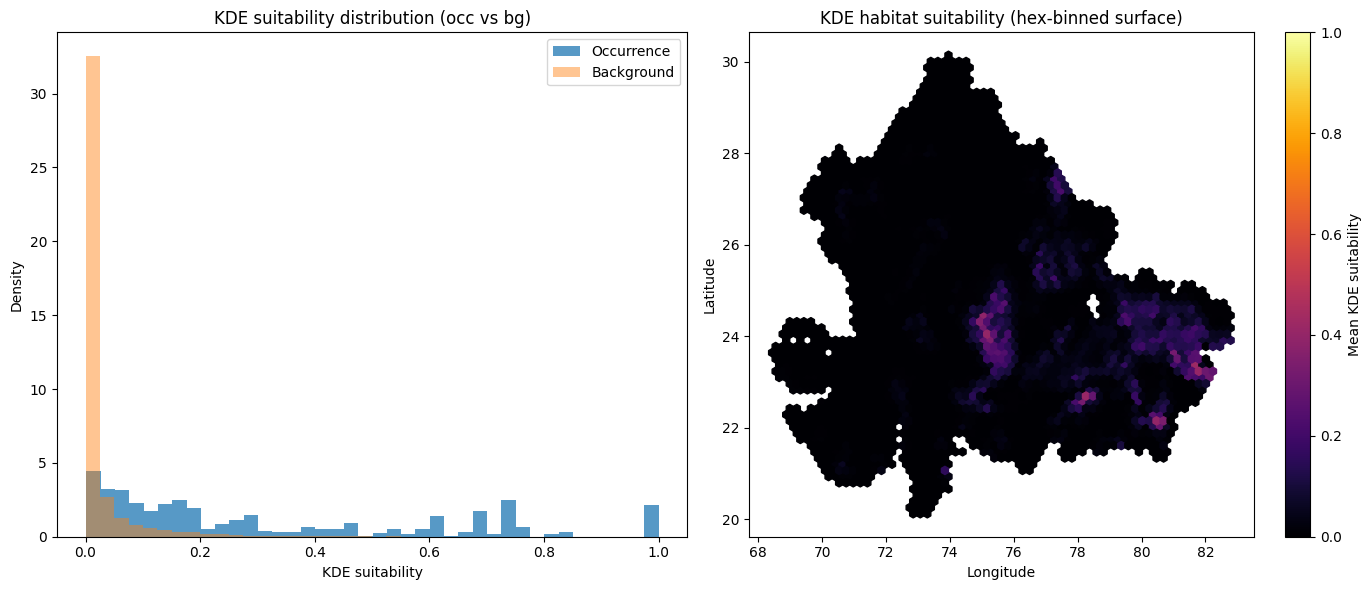

In [62]:
import json

# -------------------------------------------------
# Load combined KDE-only file
# (even if filename says "final", we enforce KDE usage)
# -------------------------------------------------
combined = pd.read_csv("combined_with_final_suit.csv")

# -------------------------------------------------
# Extract longitude / latitude from .geo column (SAFE)
# -------------------------------------------------
def extract_lon_lat(geo_str):
    if pd.isna(geo_str):
        return np.nan, np.nan
    geo = json.loads(geo_str)
    lon, lat = geo["coordinates"]   # [lon, lat]
    return lon, lat

combined[['longitude', 'latitude']] = (
    combined['.geo']
    .apply(lambda x: pd.Series(extract_lon_lat(x)))
)

combined.dropna(subset=['longitude', 'latitude'], inplace=True)

# -------------------------------------------------
# Split occurrence and background
# -------------------------------------------------
occ = combined[combined['source'] == 'occ']
bg  = combined[combined['source'] == 'bg']

# -------------------------------------------------
# Enforce KDE-only suitability
# -------------------------------------------------
if 'suit_kde' not in combined.columns:
    raise ValueError(
        "suit_kde column not found. "
        "Do NOT use suit_final or GMM-derived columns."
    )

# -------------------------------------------------
# PLOTTING
# -------------------------------------------------
plt.figure(figsize=(14, 6))

# =================================================
# 1️⃣ Histogram — DENSITY (correct for SDM imbalance)
# =================================================
plt.subplot(1, 2, 1)

plt.hist(
    occ['suit_kde'],
    bins=40,
    density=True,
    alpha=0.75,
    label='Occurrence'
)

plt.hist(
    bg['suit_kde'],
    bins=40,
    density=True,
    alpha=0.45,
    label='Background'
)

plt.xlabel('KDE suitability')
plt.ylabel('Density')
plt.title('KDE suitability distribution (occ vs bg)')
plt.legend()

# =================================================
# 2️⃣ Spatial map — HEXBIN (raster-equivalent surface)
# =================================================
plt.subplot(1, 2, 2)

hb = plt.hexbin(
    bg['longitude'],
    bg['latitude'],
    C=bg['suit_kde'],
    gridsize=65,                 # ↑ larger = smoother
    reduce_C_function=np.mean,   # mean suitability per cell
    cmap='inferno',
    vmin=0,
    vmax=1
)

plt.colorbar(hb, label='Mean KDE suitability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KDE habitat suitability (hex-binned surface)')

plt.tight_layout()
plt.show()


AUC (Area Under the Curve): 0.8664


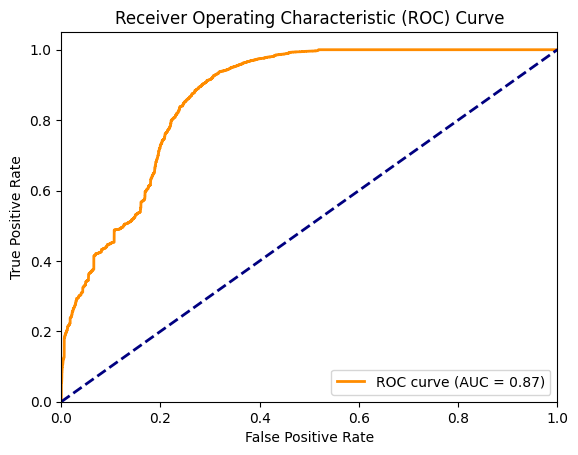

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prepare data for AUC calculation
# Use combined_final_suit_df which is known to have 'suit_final_norm' and 'source'
y_true = combined_final_suit_df['source'].apply(lambda x: 1 if x == 'occ' else 0)
y_scores = combined_final_suit_df['suit_final_norm']

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f"AUC (Area Under the Curve): {roc_auc:.4f}")

# Optional: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

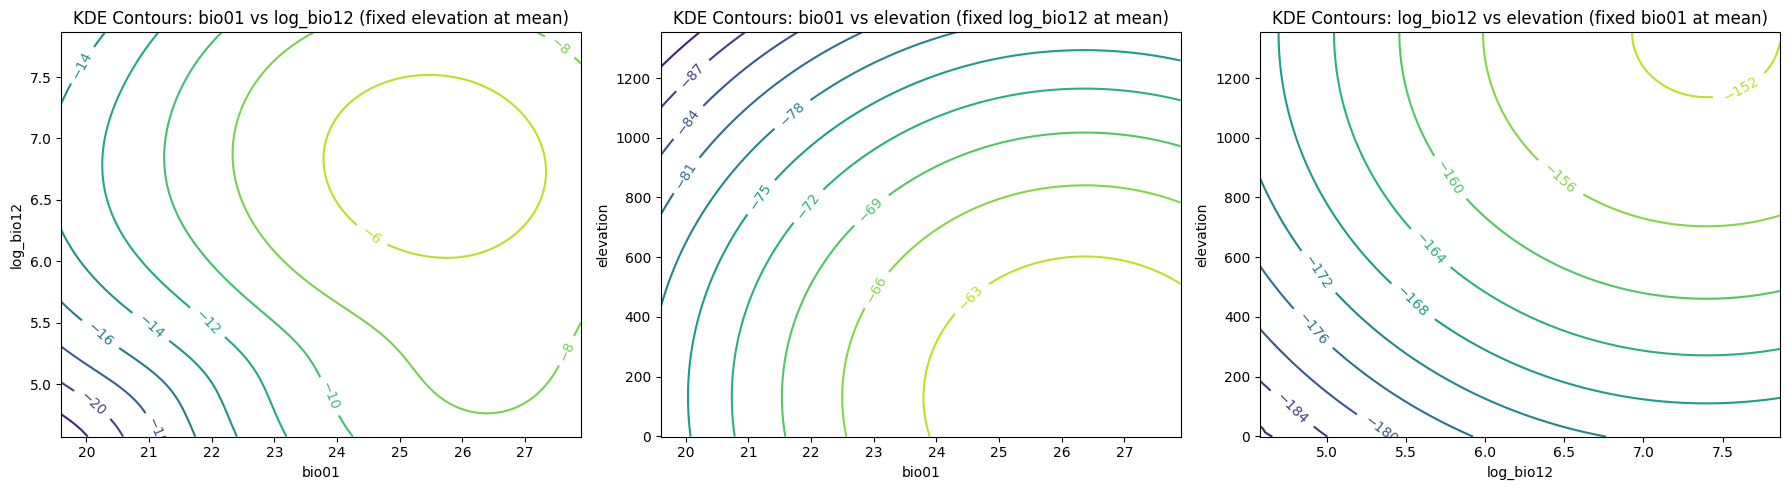

In [ ]:
# Define the environmental features
features = ['bio01', 'log_bio12', 'elevation']

# Get the mean values of the features in the scaled occurrence data
mean_scaled_features = X_occ.mean(axis=0)

# Create a function to plot KDE contours for a pair of features
def plot_kde_contours(kde_model, scaler, feature_x, feature_y, fixed_feature, fixed_value_scaled, ax):
    # Get the indices of the features
    idx_x = features.index(feature_x)
    idx_y = features.index(feature_y)
    idx_fixed = features.index(fixed_feature)

    # Create a grid of values for the two selected features
    # Use the range of the combined data for the grid limits
    x_min, x_max = combined[feature_x].min(), combined[feature_x].max()
    y_min, y_max = combined[feature_y].min(), combined[feature_y].max()

    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    grid_shape = xx.shape
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Create the full feature array with the fixed feature
    n_points = grid_points.shape[0]
    full_points = np.zeros((n_points, len(features)))
    full_points[:, idx_x] = grid_points[:, 0]
    full_points[:, idx_y] = grid_points[:, 1]
    full_points[:, idx_fixed] = fixed_value_scaled # Use scaled fixed value for prediction

    # Scale the grid points
    full_points_scaled = scaler.transform(full_points)

    # Calculate the log-likelihood of each point under the KDE
    log_likelihood = kde_model.score_samples(full_points_scaled)
    log_likelihood = log_likelihood.reshape(grid_shape)

    # Plot the contours
    contour = ax.contour(xx, yy, log_likelihood, levels=10, cmap='viridis')
    ax.clabel(contour, inline=1, fontsize=10)

    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.set_title(f'KDE Contours: {feature_x} vs {feature_y} (fixed {fixed_feature} at mean)')

# Create plots for pairs of features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# bio01 vs log_bio12 (fix elevation)
plot_kde_contours(kde_model, scaler, 'bio01', 'log_bio12', 'elevation', mean_scaled_features[features.index('elevation')], axes[0])

# bio01 vs elevation (fix log_bio12)
plot_kde_contours(kde_model, scaler, 'bio01', 'elevation', 'log_bio12', mean_scaled_features[features.index('log_bio12')], axes[1])

# log_bio12 vs elevation (fix bio01)
plot_kde_contours(kde_model, scaler, 'log_bio12', 'elevation', 'bio01', mean_scaled_features[features.index('bio01')], axes[2])

plt.tight_layout()
plt.show()

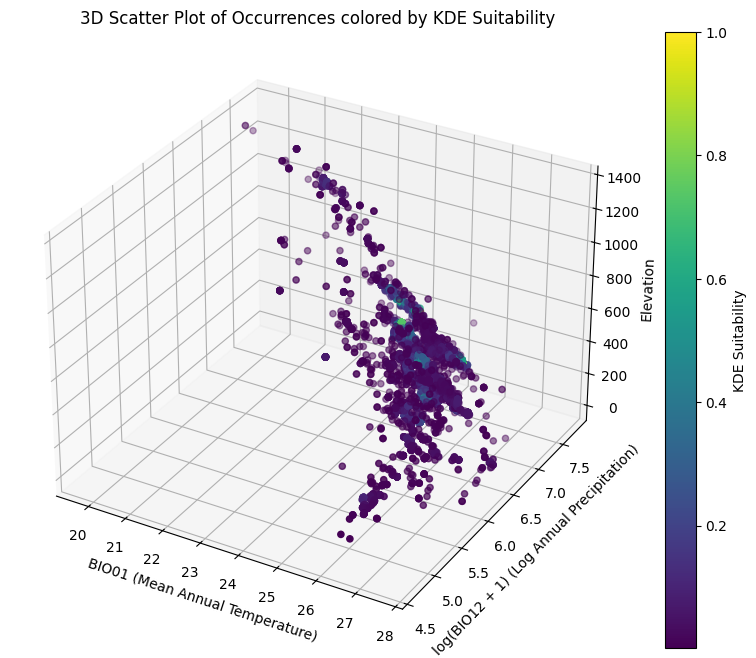

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the environmental features
features = ['bio01', 'log_bio12', 'elevation']

# Ensure occ_out DataFrame has the KDE suitability and environmental features
# If occ_out was not created in the current session, load it
if 'occ_out' not in locals():
    try:
        occ_out = pd.read_csv('occurrence_with_final_suit.csv')
    except FileNotFoundError:
        print("Error: 'occurrence_with_final_suit.csv' not found. Please run the previous steps.")
        # Exit or handle the error appropriately
else:
    # Make sure occ_out has the necessary columns, if not, add them from combined if available
    if 'suit_kde' not in occ_out.columns and 'combined' in locals():
        occ_out = combined[combined['source']=='occ'].copy()
        # Ensure suit_kde is in the combined dataframe
        if 'suit_kde' not in combined.columns:
             print("Error: 'suit_kde' not found in the 'combined' DataFrame. Please run the KDE calculation steps.")
             # Exit or handle the error appropriately


# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing KDE suitability
scatter = ax.scatter(occ_out['bio01'], occ_out['log_bio12'], occ_out['elevation'],
                     c=occ_out['suit_kde'], cmap='viridis', s=20)

# Add a color bar
cbar = fig.colorbar(scatter)
cbar.set_label('KDE Suitability')

# Set labels for the axes
ax.set_xlabel('BIO01 (Mean Annual Temperature)')
ax.set_ylabel('log(BIO12 + 1) (Log Annual Precipitation)')
ax.set_zlabel('Elevation')
ax.set_title('3D Scatter Plot of Occurrences colored by KDE Suitability')

plt.show()